<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

<font color="#d3d3d3"><h1><b>Reminder for all students and instructors to use the same version of the project notebooks (beginner or advanced)</b></h1></font>

![](http://static1.squarespace.com/static/56ccc8724c2f8548059fbcfe/58f6daea15d5dbcc64ef63aa/5cae2d770d92977242838baa/1557942174418/SW-DistractedDriving-Clean-1.jpg?format=1500w)

In this notebook we will be:
1.   Visualizing Saliency Maps
2.   Evaluating our ML Models


# Milestone 1: Saliency maps

<font color="#de3023"><h2><b>Note: these blocks will take a minute to execute, so make sure to run them first thing!</b></h2></font>


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore')
!pip install tf-keras-vis tensorflow > /dev/null

def label_to_numpy(labels):
  final_labels = np.zeros((len(labels), 4))
  for i in range(len(labels)):
    label = labels[i]
    if label == 'Attentive':
      final_labels[i,:] = np.array([1, 0, 0, 0])
    if label == 'DrinkingCoffee':
      final_labels[i,:] = np.array([0, 1, 0, 0])
    if label == 'UsingMirror':
      final_labels[i,:] = np.array([0, 0, 1, 0])
    if label == 'UsingRadio':
      final_labels[i,:] = np.array([0, 0, 0, 1])
  return final_labels

def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)

def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    metadata = metadata[keep_idx]

    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    return metadata

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_image(data, num_ims, figsize=(8,6), labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    print(data.shape)
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(-1,image_shape[0],image_shape[1],image_shape[2])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest

    nrows=int(np.sqrt(num_ims))
    ncols=int(np.ceil(num_ims/nrows))
    print(nrows,ncols)
    count=0
    if nrows==1 and ncols==1:
      print('Label: %s'%label)
      plt.imshow(image)
      plt.show()
    else:
      print(labels)
      fig = plt.figure(figsize=figsize)
      for i in range(nrows):
        for j in range(ncols):
          if count<num_ims:
            fig.add_subplot(nrows,ncols,count+1)
            plt.imshow(image[count])
            count+=1
      fig.set_size_inches(18.5, 10.5)
      plt.show()



  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))

    for layer in model.layers:
      if hasattr(layer,"activation"):
        stringlist.append(str(layer.activation))

    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.25, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.01, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 0.5):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 0.5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = tensorflow.keras.optimizers.RMSprop(learning_rate=1e-4)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters

### defining project variables
# file variables
# image_data_url       = 'https://drive.google.com/uc?id=1qmTuUyn0525-612yS-wkp8gHB72Wv_XP'
# metadata_url         = 'https://drive.google.com/uc?id=1OfKnq3uIT29sXjWSZqOOpceig8Ul24OW'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 4
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'

###
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/metadata.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/image_data.npy'


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_image = lambda data, num_ims,figsize=(8,6), labels = [], index = None: helpers.plot_image(data = data, num_ims=num_ims, figsize=figsize,labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

#monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

metadata.csv        100%[===================>] 200.33K  --.-KB/s    in 0.002s  
image_data.npy      100%[===================>] 423.61M   135MB/s    in 3.1s    


Before we get started, let's load in a CNN model as we did on the previous day. For convenience, we provide this code for you to get you started.

**Run the below code. You are now very familiar with this code!**

Epoch 1/10
211/211 [==============================] - 5s 7ms/step - loss: 1.3861 - accuracy: 0.3098 - val_loss: 1.3226 - val_accuracy: 0.2761
Epoch 2/10
211/211 [==============================] - 1s 6ms/step - loss: 1.2835 - accuracy: 0.3980 - val_loss: 1.2798 - val_accuracy: 0.4098
Epoch 3/10
211/211 [==============================] - 1s 6ms/step - loss: 1.1758 - accuracy: 0.4826 - val_loss: 1.3321 - val_accuracy: 0.2967
Epoch 4/10
211/211 [==============================] - 1s 4ms/step - loss: 1.0507 - accuracy: 0.5610 - val_loss: 1.3524 - val_accuracy: 0.3435
Epoch 5/10
211/211 [==============================] - 1s 4ms/step - loss: 0.9303 - accuracy: 0.6379 - val_loss: 1.4251 - val_accuracy: 0.3663
Epoch 6/10
211/211 [==============================] - 1s 4ms/step - loss: 0.8324 - accuracy: 0.6834 - val_loss: 1.7038 - val_accuracy: 0.3283
Epoch 7/10
211/211 [==============================] - 1s 4ms/step - loss: 0.7475 - accuracy: 0.7268 - val_loss: 1.8738 - val_accuracy: 0.3315
Epoch 

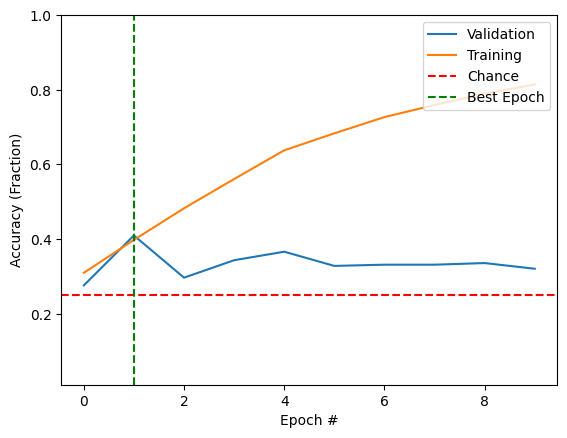

CNN


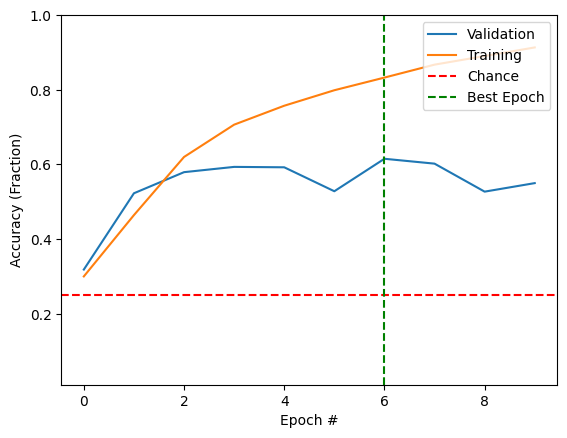

In [ ]:
X_train, y_train_str = get_train_data(flatten=True)
X_test, y_test_str = get_test_data(flatten=True)

X_train = X_train.reshape([-1, 64, 64, 3])
X_test = X_test.reshape([-1, 64, 64, 3])

# save string versions of labels
y_train = y_train_str
y_test = y_test_str

# convert labels into numpy vectors (one-hot encoding!)
y_train = label_to_numpy(y_train)
y_test = label_to_numpy(y_test)

dense = DenseClassifier(hidden_layer_sizes = (128,64))
cnn = CNNClassifier(num_hidden_layers = 5)

dense.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
cnn.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])

print('Dense')
plot_acc(dense.history)

print('CNN')
plot_acc(cnn.history)


Now, let's view the saliency map of several of our images. A saliency map is used to visualize which pixels in an input image are the most influential, or **salient**, when the network is making a decision. In other words, this means that we can show which pixels in the input image the network is looking at when classifying an image.

In the following example, we show an photo of a tabby cat, and we're interested in which pixels were most important for the model when recognizing the cat. The pixels that were most important to the model will show up on a heatmap with warmer colors. This is one example of a **saliency map**.

![saliency_map](https://i.ibb.co/ygBG5Sb/tabby-heatmap.png)

If you want to explore saliency maps more, check out [this website](https://lrpserver.hhi.fraunhofer.de/image-classification) for an interactive demo.

In [ ]:
#@title Run this to prepare your saliency map visualization tools!
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

X_train, y_train_str = get_train_data(flatten=True)
X_test, y_test_str = get_test_data(flatten=True)

X_train = X_train.reshape([-1, 64, 64, 3])
X_test = X_test.reshape([-1, 64, 64, 3])

# save string versions of labels
y_train = y_train_str
y_test = y_test_str

# convert labels into numpy vectors (one-hot encoding!)
y_train = label_to_numpy(y_train)
y_test = label_to_numpy(y_test)

replace2linear = ReplaceToLinear()

images = []
for i, title in enumerate(y_test_str):
  dim = (64, 64)
  img = np.array(cv2.resize(X_test[i], dim))
  images.append(img)
images = np.asarray(images)

def getImageSamples():
  image_samples = []
  image_samples_labels = []
  idx = random.randint(0, 230)
  for i in range(4):
    image_samples.append(images[idx])
    image_samples_labels.append(y_test_str[idx])
    idx = idx + 230
  image_samples = np.asarray(image_samples)
  return image_samples, image_samples_labels

def plot_vanilla_saliency_of_a_model(model, X_input, image_titles):
    score = CategoricalScore(list(range(X_input.shape[0])))

    # Create Saliency visualization object
    saliency = Saliency(model,
                        model_modifier=ReplaceToLinear(), # replaces the activation function of the chosen layer (here is the last layer) to linear function (for visualization)
                        clone=True)

    # Generate saliency map
    saliency_map = saliency(score, X_input)

    # Rendering
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(X_input[i])
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Plot saliencies
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(saliency_map[i], cmap='jet')
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()


## Exercise: Saliency Map

Run this cell to view a saliency map for images from each distinct class.

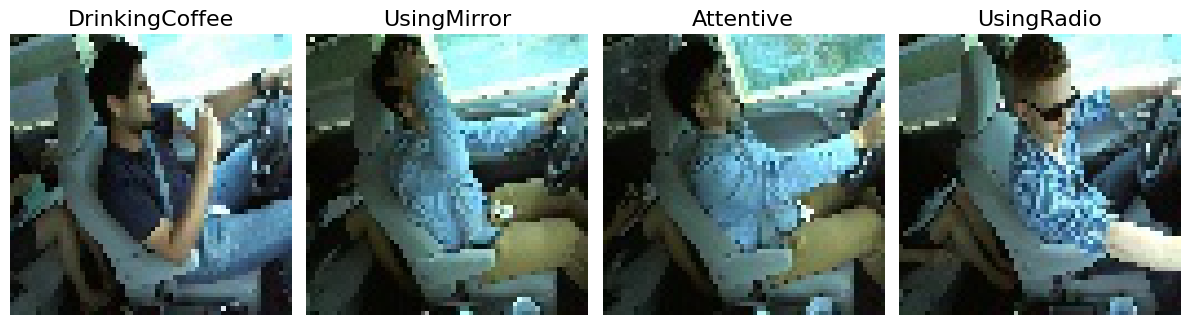

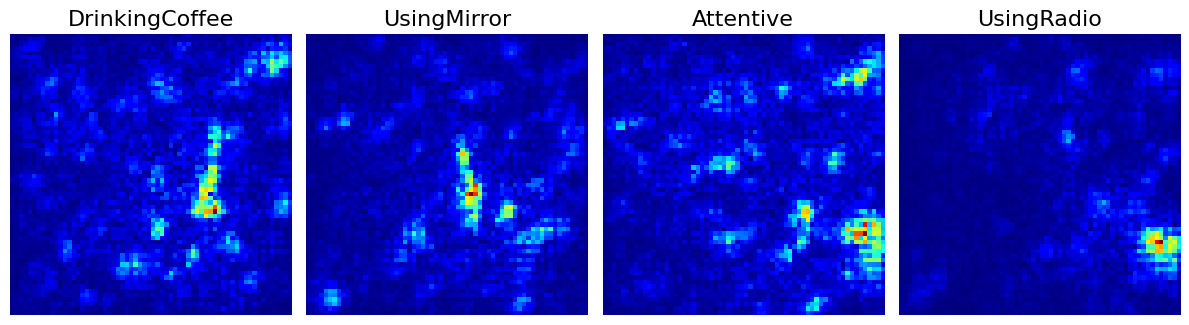

In [ ]:
imgs, imgs_labels = getImageSamples()
plot_vanilla_saliency_of_a_model(cnn, imgs, imgs_labels)

## Instructor-Led Discussion: Saliency maps

With your group, discuss:

**What differences do you notice between the saliency maps of the different classes?**

**What might be the underlying cause of these differences?**

# Milestone 2: Model Evaluation

## Activity 2a. How did we do on predicting distracted drivers?

### Exercise (Coding) | Within a student group

We use one of our best models from the previous notebook, the VGG16 classifier.

In [ ]:
#@title Run this cell to import and train the VGG16 model

# get data
X_train, y_train_str = get_train_data(flatten=True)
X_test, y_test_str = get_test_data(flatten=True)

X_train = X_train.reshape([-1, 64, 64, 3])
X_test = X_test.reshape([-1, 64, 64, 3])

# save string versions of labels
y_train = y_train_str
y_test = y_test_str

# convert labels into numpy vectors (one-hot encoding!)
y_train = label_to_numpy(y_train)
y_test = label_to_numpy(y_test)

from tensorflow.keras.applications.vgg16 import VGG16

# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

# we add the first 12 layers of vgg to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(4, activation = 'softmax'))

# finally, we build the vgg model and turn it on so we can use it!
vgg_model.compile(loss = 'categorical_crossentropy',
          optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.95),
          metrics=['accuracy'])

# grab our augmented training manual
# and hand it to our model to train
vgg_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])


Epoch 1/10
211/211 [==============================] - 15s 52ms/step - loss: 0.9154 - accuracy: 0.5885 - val_loss: 1.7141 - val_accuracy: 0.4641
Epoch 2/10
211/211 [==============================] - 11s 51ms/step - loss: 0.1542 - accuracy: 0.9569 - val_loss: 2.2215 - val_accuracy: 0.4674
Epoch 3/10
211/211 [==============================] - 11s 53ms/step - loss: 0.0754 - accuracy: 0.9802 - val_loss: 1.0688 - val_accuracy: 0.6620
Epoch 4/10
211/211 [==============================] - 11s 51ms/step - loss: 0.0630 - accuracy: 0.9814 - val_loss: 1.1539 - val_accuracy: 0.6380
Epoch 5/10
211/211 [==============================] - 11s 54ms/step - loss: 0.0354 - accuracy: 0.9912 - val_loss: 0.9479 - val_accuracy: 0.6891
Epoch 6/10
211/211 [==============================] - 11s 54ms/step - loss: 0.0239 - accuracy: 0.9939 - val_loss: 1.1294 - val_accuracy: 0.6924
Epoch 7/10
211/211 [==============================] - 12s 55ms/step - loss: 0.0237 - accuracy: 0.9929 - val_loss: 1.7241 - val_accuracy:

As we learned last week, total accuracy does not reflect all that we want to know about a model's performance. It's just one metric out of many possible metrics for evaluating models.

In the case of detection of unsafe driving, we may be more interested in other quantities, such as 'how accurate were we on the distracted images?' or 'how accurate were we on the attentive category?' or 'how much of the attentive drivers were confused for distracted driving?' or vice versa.



Our metrics for classification can be described in terms of a 'confusion matrix', shown below.

![Confusion Matrix](https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In a confusion matrix, we think in terms of 'actual' and 'predicted values'. If we take Distracted Driving (DrinkingCoffee, UsingMirror, or UsingRadio) = 1/Positive and Attentive = 0/Negative, then...

* True positive: True distracted driving prediction: Distracted driving predicted as distracted driving
* True negative: True attentive prediction: Attentive predicted as attentive
* False positive: False distracted driving prediction: Attentive mistaken as distracted driving
* False negative: False attentive prediction: Distracted driving mistaken as attentive


The `sklearn` package makes calculating confusion matrices very quick! Its `metrics` submodule actually comes with a `confusion_matrix` tool. Let's start by grabbing that.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

To use `confusion_matrix`, we need:
* `labels`: the labels of the data (1 - DISTRACTED DRIVING or 0 - ATTENTIVE)
* `predictions`: what our model thinks the labels are

To get `predictions`, we have to give our model our test data `X_test`, and ask it to give us `predictions`. We'll do that with



In [ ]:
predictions = vgg_model.predict(X_test)
predictions = np.argmax(predictions,axis=1)

29/29 [==============================] - 1s 16ms/step


## Exercise: Confusion matrix for distracted vs. non-distracted driving

First, write code below to calculate the accuracy of the classifier. Note that to complete this, you will need to transform the current 4-way classification into a binary (2-way) classification. That is, we will group all of UsingRadio, UsingMirror, and DrinkingCoffee into a single class representing all of distracted driving in general.

In [ ]:
# First, covert the 4 labels to 2 numbers.
# If the true label is 'Attentive', then we add 0 (for attentive) to final_labels. Otherwise,
# for all other labels, we add a label of 1 (for distracted). Hint: .append() will add an element to a list!
final_labels = []
for label in y_test_str:
  if label == "Attentive":
    final_labels.append(0)
  else:
    final_labels.append(1)
  ### FILL IN THIS LOOP ###

# Now, we change our final predictions to 0 and 1. That is, if the prediction
# currently is 0, then add 0 (for attentive) to binary_predictions. Otherwise,
# add 1 (for distracted).
binary_predictions = []
for label in predictions:
  if label == 0:
    binary_predictions.append(0)
  else:
    binary_predictions.append(1)
  ### FILL IN THIS LOOP ###

# Checking if the lists have been defined allows the whole notebook to execute
# even if this cell has not been completed
if binary_predictions and final_labels:
  print('Accuracy is %d %%'%(accuracy_score(final_labels, binary_predictions)*100.0))

Accuracy is 89 %


### Discuss: Is this good accuracy?

Now let's get our confusion matrix, and split it out into true positive, true negative, false positive, and false negative!

In [ ]:
confusion = confusion_matrix(final_labels, binary_predictions)
print(confusion)

tp  = confusion[1][1]
tn  = confusion[0][0]
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

[[182  48]
 [ 48 642]]
True positive: 642
True negative: 182
False positive: 48
False negative: 48


We can visualize the confusion matrix with seaborn to make it easier for our eyes...

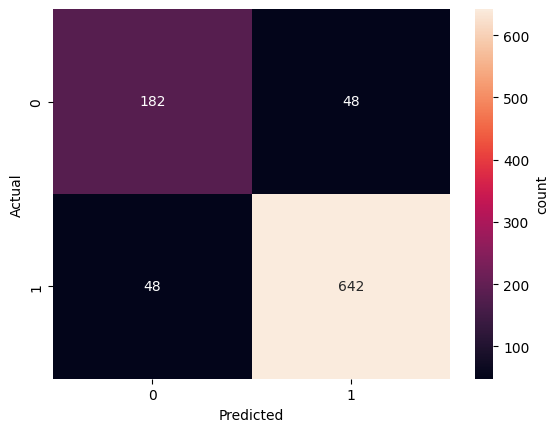

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

### Exercise (Discussion)

**Discuss with your instructor what you got and also...**

What is more problematic? False positives or False negatives?

Which of these metrics do we want to keep low?


## Exercise: Precision and Recall Calculation

Recall our discussion of precision and recall. Discuss with the course the difference between precision and recall. Then, print the precision and recall of the model and discuss with the class the implications of precision and recall in terms of distracted driving.

In [ ]:
## YOUR CODE HERE

## END CODE

# Optional Exercise: Maintaining Privacy

A common problem in video recording is maintaining privacy of users. If you have time, add privacy to all of our training and test data by modifying the images to have red boxes over the faces. Then, retrain the CNN and evaluate the performance.

In [ ]:
### YOUR CODE HERE

### END CODE